# **East Africa drought study - model fitting**

In [1]:
library("copula")
library("plyr")

# load precip data and convert to log for fitting purposes
# df <- read.csv("data/gmst-nino-chirps.csv")
df <- read.csv("data/gmst-nino-cpc.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log10(df[,v]))) # ensures results match climate explorer

---
## **Linear model fits**

- Choose parameters by fitting linear model & checking significance
- Treat GMST and Nino3.4rel as independent, since Nino index is detrended

In [27]:
df <- read.csv("data/gmst-nino-chirps.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log(df[,v]))) # use log10 to match climate explorer

In [26]:
rbind.fill(sapply(colnames(df)[5:ncol(df)], function(v) {
    if(grepl("mam", v)) {
        nino = "nino_mam"
    } else {
        nino = "nino_ond"
    }
    summ_gmst <- summary(lm(get(v) ~ gmst, df))
    summ_nino <- summary(lm(get(v) ~ get(nino), df))
    summ_both <- summary(lm(get(v) ~ gmst + get(nino), df))
    
    data.frame("variable" = v, 
               # "nino_cov" = nino,
               "gmst" = c(paste0(round(summ_gmst$coefficients[-1,1], 4), c("", "*")[(summ_gmst$coefficients[-1,4] < 0.05) + 1])),
               "nino" = c(paste0(round(summ_nino$coefficients[-1,1], 4), c("", "*")[(summ_nino$coefficients[-1,4] < 0.05) + 1])),
               "both" = c(paste0(round(summ_both$coefficients[-1,1], 4), c("", "*")[(summ_both$coefficients[-1,4] < 0.05) + 1], collapse = " & ")))
}, simplify = F))

variable,gmst,nino,both
<chr>,<chr>,<chr>,<chr>
pr_ond,0.3217,0.1769*,0.4744* & 0.1931*
pr_mam,-0.1385,0.0359,-0.1203 & 0.0247
pr12,0.0586,0.0898*,0.1332 & 0.0944*
pr24,0.095,0.0266,0.121 & 0.0308


---
## **New methods used in this analysis**

In [30]:
ns_mle_2cov <- function(pars = c(mu0, sigma0, alpha, beta), cov1, cov2, x, dist, fittype) {
    
    # nonstationary log-likelihood function with two parameters
    
    if(fittype == "fixeddisp") {
        
        const = exp((pars["alpha"] * cov1 + pars["beta"] * cov2) / pars["mu0"])
        loc = pars["mu0"] * const
        scale = pars["sigma0"] * const
        
    } else if(fittype == "shift") {
        loc = pars["mu0"] + pars["alpha"] * cov1 + pars["beta"] * cov2
        scale = pars["sigma0"]
        
    } else {
        print(paste(fittype,"not implemented"))
        return()
    }
    
    # return negative log-likelihood to be minimised
    ddist <- get(paste0("d", dist))
    return(-sum(ddist(x, mean = loc, sd = scale, log = T)))
}


ns_mle <- function(pars = c(mu0, sigma0, alpha), cov1, x, dist, fittype) {

    # nonstationary log-likelihood function with one parameters
    # using separate function to avoid optimising a redundant parameter, which can lead to fitting issues
    
    if(fittype == "fixeddisp") {
        
        const = exp((pars["alpha"] * cov1) / pars["mu0"])
        loc = pars["mu0"] * const
        scale = pars["sigma0"] * const
        
    } else if(fittype == "shift") {
        loc = pars["mu0"] + pars["alpha"] * cov1
        scale = pars["sigma0"]
        
    } else {
        print(paste(fittype,"not implemented"))
        return()
    }
    
    # return negative log-likelihood to be minimised
    ddist <- get(paste0("d", dist))
    return(-sum(ddist(x, mean = loc, sd = scale, log = T)))
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# wrapper to fit nonstationary fixed-dispersion model

fit_ns <- function(dist, type = "fixeddisp", data, varnm, covnm_1, covnm_2 = NA, lower = F, ...) {
    
    # currently only works for distributions fully specified by mean & sd: only tested for normal, lognormal
    if(! dist %in% c("norm", "lnorm")) {
        print("Not yet implemented: use norm or lnorm")
        return()
    }
    
    x <- data[,varnm]
    
    # fit model with appropriate number of parameters, pad if necessary
    if(is.na(covnm_2)) {
        init <- c("mu0" = mean(x), "sigma0" = sd(x), "alpha" = 0)
        fitted <- suppressWarnings(optim(par = init, ns_mle, cov1 = df[,covnm_1], x = x, dist = dist, fittype = type, ...))
        fitted[["par"]]["beta"] <- 0
        mdl_call <- paste0(varnm," ~ ",covnm_1)
    } else {
        init <- c("mu0" = mean(x), "sigma0" = sd(x), "alpha" = 0, "beta" = 0)
        fitted <- suppressWarnings(optim(par = init, ns_mle_2cov, cov1 = df[,covnm_1], cov2 = df[,covnm_2], x = x, dist = dist, fittype = type, ...))
        mdl_call <- paste0(varnm," ~ ",covnm_1, " + ", covnm_2)
    }
        
    # estimate & return parameters & assorted useful information
    fitted[["dist"]] <- dist
    fitted[["type"]] <- type
    fitted[["lower"]] <- lower
    fitted[["call"]] <- mdl_call
    fitted[["varnm"]] <- varnm
    fitted[["covnm_1"]] <- covnm_1
    fitted[["covnm_2"]] <- covnm_2
    fitted[["x"]] <- x
    fitted[["cov1"]] <- df[,covnm_1]
    if(is.na(covnm_2)) {
        fitted[["cov2"]] <- 0
    } else {
        fitted[["cov2"]] <- df[,covnm_2]
    }

    return(fitted)
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ns_pars <- function(mdl, cov1 = NA, cov2 = 0) {
    
    # get nonstationary parameters from fitted model
    
    pars <- mdl$par
    if(is.na(cov1[1])) cov1 <- mdl$cov1
    
    if(mdl$type == "fixeddisp") {
        
        ns_const = exp((pars["alpha"] * cov1 + pars["beta"] * cov2) / pars["mu0"])
        loc = pars["mu0"] * ns_const
        scale = pars["sigma0"] * ns_const
        
    } else if(mdl$type == "shift") {
        loc = pars["mu0"] + pars["alpha"] * cov1 + pars["beta"] * cov2
        scale = pars["sigma0"]
        
    } else {
        print(paste(mdl$type,"not implemented"))
        return()
    }
    return(list("loc" = loc, "scale" = scale))
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

map_to_u <- function(mdl, x, cov1 = NA, cov2 = 0) {
    
    # convert from nonstationary distribution to stationary uniform (PIT)
    
    pars <- ns_pars(mdl, cov1 = cov1, cov2 = cov2)
    if(missing(x)) x <- mdl$x
    pit <- get(paste0("p", mdl$dist))(x, mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
    
    return(pit)
}


map_from_u <- function(u, mdl, cov1, cov2 = 0) {
    
    # convert from U(0,1) to stationary distribution with specified covariates
    
    pars <- ns_pars(mdl, cov1 = cov1, cov2 = cov2)
        
    u_transformed <- get(paste0("q", mdl$dist))(u, mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
    return(u_transformed)
}

In [31]:
df <- read.csv("data/gmst-nino-cpc.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log10(df[,v]))) # ensures results match climate explorer

# check fitted parameters against climate explorer to confirm working properly
round(fit_ns("norm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)$par, 3)  # expect 2.114, 0.193, 0.077
round(fit_ns("norm", "shift", df, varnm = "tas_ond", covnm_1 = "gmst", lower = F)$par, 3)     # expect 25.848, 0.492, 0.990

mu0 sigma0  alpha   beta 
 2.114  0.193  0.074  0.000

mu0 sigma0  alpha   beta 
25.847  0.492  0.989  0.000

In [32]:
# also check that results match for lognormal fitting / normal fitting to log precip
df <- read.csv("data/gmst-nino-cpc.csv")
df["log_pr"] <- log(df$pr_ond)

round(fit_ns("norm", "fixeddisp", df, varnm = "log_pr", covnm_1 = "gmst", lower = T)$par, 3)
round(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)$par, 3)

mu0 sigma0  alpha   beta 
 4.869  0.444  0.171  0.000

mu0 sigma0  alpha   beta 
 4.868  0.444  0.172  0.000

---
## **Bivariate analysis using ``copula`` package**

### **Test by replicating Mariam's analysis**

In [33]:
df <- read.csv("data/gmst-nino-cpc.csv")

# fit marginal distributions
# df["log_pr"] <- log10(df$pr_ond); mdl_pr <- fit_ns("norm", "fixeddisp", df, varnm = "log_pr", covnm_1 = "gmst", lower = T)
mdl_pr <- fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)
mdl_tas <- fit_ns("norm", "shift", df, varnm = "tas_ond", covnm_1 = "gmst", lower = F)

# transform marginals to U
u_pr <- map_to_u(mdl_pr, mdl_pr$x)
u_tas <- map_to_u(mdl_tas, mdl_tas$x)

# fit copula to u,v pairs
fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_tas), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula

In [57]:
copula_mesh <- function(mdl_x, mdl_y, copula, cov1, cov2 = 0, xrange, yrange, n = 32) {
    
    # compute joint exceedances over regular grid for easy plotting
    
    if(missing(xrange)) xrange <- range(pretty(mdl_x$x))
    if(missing(yrange)) yrange <- range(pretty(mdl_y$x))
    
    # define the regular mesh for plotting
    x_mesh <- seq(xrange[1], xrange[2],length.out = n)
    y_mesh <- seq(yrange[1], yrange[2], length.out = n)
    
    # convert the regular mesh to U space
    x_umesh <- map_to_u(mdl_x, x_mesh, cov1 = cov1, cov2 = cov2)
    y_umesh <- map_to_u(mdl_y, y_mesh, cov1 = cov1, cov2 = cov2)
    
    return(list("x" = x_mesh, "y" = y_mesh, "z" = sapply(y_umesh, function(y) sapply(x_umesh, function(x) pCopula(cbind(x,y), copula)))))
}
                                                                                     
# Get return periods, return levels etc from model                                  
model_delta <- function(mdl_x, mdl_y, copula, x, y, cov1_hist, cov2_hist = 0, dI_x_rel = F, dI_y_rel = F) {
    
    u_x <- map_to_u(mdl_x, x)[mdl_x$x == x]
    u_y <- map_to_u(mdl_y, y)[mdl_y$x == y]
        
    uhist_x <- map_to_u(mdl_x, x, cov1 = cov1_hist, cov2 = cov2_hist)
    uhist_y <- map_to_u(mdl_y, y, cov1 = cov1_hist, cov2 = cov2_hist)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # return levels
    
    rl_hist_x = map_from_u(u_x, mdl_x, cov1 = cov1_hist, cov2 = cov2_hist)
    rl_hist_y = map_from_u(u_y, mdl_y, cov1 = cov1_hist, cov2 = cov2_hist)
    
    if(dI_x_rel) { dI_x = (x - rl_hist_x) / rl_hist_x * 100 } else { dI_x = x - rl_hist_x }
    if(dI_y_rel) { dI_y = (y - rl_hist_y) / rl_hist_y * 100 } else { dI_y = y - rl_hist_y }
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # return periods 
    
    rp_2022_x = 1/u_x
    rp_2022_y = 1/u_y
    rp_2022_joint = 1/pCopula(cbind(u_x, u_y), copula)
    
    rp_hist_x = 1/uhist_x
    rp_hist_y = 1/uhist_y
    rp_hist_joint = 1/pCopula(cbind(uhist_x, uhist_y), copula)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    res <- data.frame("rp_hist" = c(rp_hist_x, rp_hist_y, rp_hist_joint),
                      "rp_2022" = c(rp_2022_x, rp_2022_y, rp_2022_joint),
                      "prob_ratio" = c(rp_hist_x / rp_2022_x, rp_hist_y / rp_2022_y, rp_hist_joint / rp_2022_joint),
                      "rl_hist" = c(rl_hist_x, rl_hist_y, NA),
                      "rl_2022" = c(x, y, NA),
                      "delta_I" = c(dI_x, dI_y, NA),
                      row.names = c(mdl_x$varnm, mdl_y$varnm, "joint"))
    return(res)
}

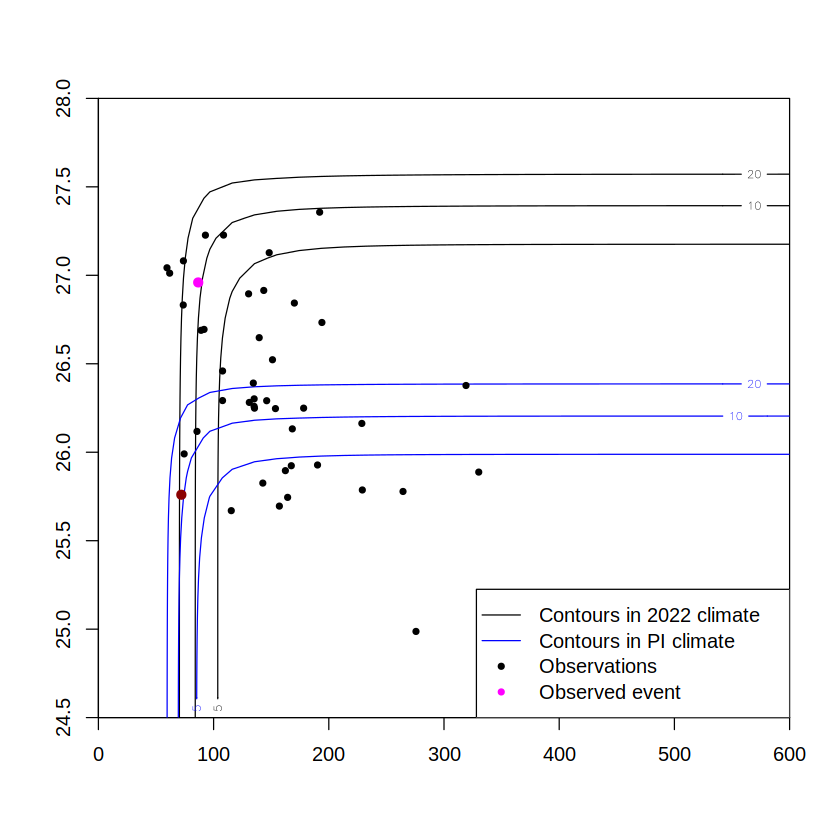

In [66]:
par(pch = 20, xaxs = "i", yaxs = "i")

contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022], yrange = c(24.5, 28)), levels = 1/c(5,10,20), labels = c(5,10,20))
contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022] - 1.2, yrange = c(24.5, 28)), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)
points(mdl_pr$x, mdl_tas$x, pch = 20)
points(mdl_pr$x[df$year == 2022], mdl_tas$x[df$year == 2022], pch = 20, col = "magenta", cex = 1.5)

# add event of same magnitude in historical climate
points(map_from_u(u_pr[df$year == 2022], mdl_pr, cov1 = df$gmst[df$year == 2022]-1.2),
       map_from_u(u_tas[df$year == 2022], mdl_tas, cov1 = df$gmst[df$year == 2022])-1.2, col = "darkred", cex = 1.5)

legend("bottomright", c("Contours in 2022 climate", "Contours in PI climate", "Observations", "Observed event"), col = c("black", "blue", "black", "magenta"), lty = c(1,1,NA,NA), pch = c(NA,NA,20,20))

In [59]:
model_delta(mdl_pr, mdl_tas, cfit, x = df[df$year == 2022, "pr_ond"], y = df[df$year == 2022, "tas_ond"], cov1_hist = df[df$year == 2022, "gmst"]-1.2)

,rp_hist,rp_2022,prob_ratio,rl_hist,rl_2022,delta_I
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
pr_ond,4.824405,9.271601,0.5203421,71.98893,86.65775,14.668810
tas_ond,417.070376,2.923771,142.6480789,25.77291,26.95972,1.186811
joint,459.603482,11.377262,40.3966688,NA,NA,NA


### **Panel plot of fitted models**

- needs to be modified to work with new functions above

Warning message in rug(df$pr_ond, lwd = 2):
“some values will be clipped”


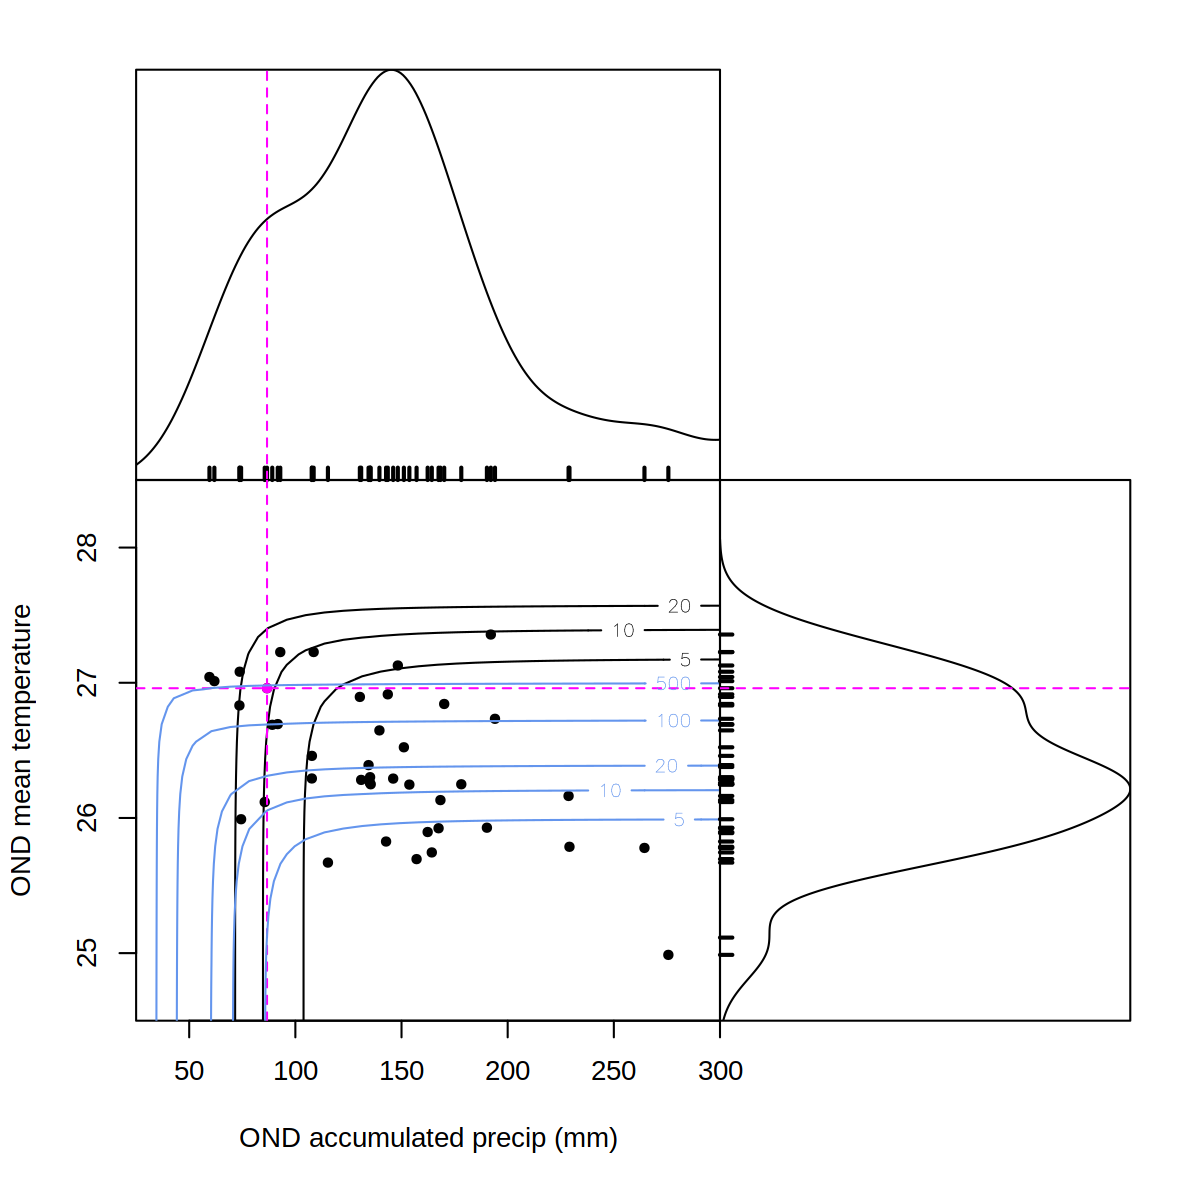

In [509]:
rc = c(1,1); w = 6; h = w; options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20, xaxs = "i", yaxs = "i")
layout(matrix(c(1,2,3,4),2,2), widths = c(3,2), heights = c(2,3))

par(mar = c(0,4.1,2.1,0))
plot(density(df$pr_ond), xaxt = "n", yaxt = "n", xlab = "", xlim = range(pr_mesh), ylab = "", main = "", col = "black")
rug(df$pr_ond, lwd = 2)
abline(v = df$pr_ond[df$year == "2022"], col = "magenta", lty = 2)

par(mar = c(5.4,4.1,0,0))
contour(z_2022, levels = 1/c(5,10,20), labels = c(5,10,20), xlab = "OND accumulated precip (mm)", ylab = "OND mean temperature")
points(df$pr_ond, df$tas_ond)
points(df$pr_ond[df$year == 2022], df$tas_ond[df$year == 2022], col = "magenta")
abline(v = df$pr_ond[df$year == "2022"],, h = df$tas_ond[df$year == "2022"], col = "magenta", lty = 2)
contour(z_hist, levels = 1/c(5,10,20,100,500), labels = c(5,10,20,100,500), col = "cornflowerblue", add = T)

plot.new()
# par(mar = c(0,0,2.1,2.1))
# contour(kde2d(u_tas, u_pr), col = "skyblue", main = "", xaxt = "n", yaxt = "n")
# points(u_tas, u_pr, pch = 4)
# contour(cfit, dCopula, add = T)

par(mar = c(5.4,0,0,2.1))
dns <- density(df$tas_ond)
plot(dns$y, dns$x, yaxt = "n", xaxt = "n", xlab = "", ylim = range(tas_mesh), type = "l", col = "black")
rug(df$tas_ond, side = 2, lwd = 2)
abline(h = df$tas_ond[df$year == "2022"], col = "magenta", lty = 2)

# probably better to replot with CDF on each axis? Or return level plot?